# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
Path = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN


## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [3]:
rec_size = 90
l = 6
s = 1
beta = 2
alpha = 2
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'

## Top n recommendations

return seuqneces with top n ucb score. 

In [4]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta)

In [5]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (1594, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg


## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [6]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta)

In [7]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (1594, 20)
X test shape:  (3873, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (267, 23)
X train shape:  (1595, 20)
X test shape:  (3872, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (268, 23)
X train shape:  (1596, 20)
X test shape:  (3871, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (269, 23)
X train shape:  (1597, 20)
X test shape:  (3870, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (270, 23)
X train shape:  (1598, 20)
X test shape:  (3869, 20)
create kernel instance
init kernel
finish creating kernel instance
gp_reg fit
gp_reg pred
finish reg
train size  (271, 23)
X train shape:  (1599, 20)
X test shape:  (3868, 20)
create kernel instance
init kernel
finish creating kernel instance


## Recommendation results

In [8]:
gpbucb_rec_df

,index,AVERAGE,Group,Name,Plate,Pred Mean,Pred Std,Pred UCB,RBS,RBS6,...,Rep8,Rep9,Round,STD,Unnamed: 0,train_test,label,pred mean,pred std,ucb
0,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,GGCGCT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.082667,0.683853,2.450373
1,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAGGTATACAT,GGCAGG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.135211,0.623996,2.383204
2,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGAGTATACAT,CAGGAG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.144838,0.604258,2.353354
3,2478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACCGAGGTATACAT,CCGAGG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.203305,0.566440,2.336185
4,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,GGGGCT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.052431,0.633536,2.319502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACCTGAGTATACAT,CCTGAG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.614033,0.608637,1.831307
86,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAGCTATACAT,GGCAGC,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.623754,0.600773,1.825300
87,2992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATAGGTTTATACAT,TAGGTT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.603362,0.610830,1.825021
88,1382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCCTCTATACAT,GGCCTC,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.611148,0.603947,1.819042


In [9]:
top_n_rec_df

,index,AVERAGE,Group,Name,Plate,Pred Mean,Pred Std,Pred UCB,RBS,RBS6,...,Rep8,Rep9,Round,STD,Unnamed: 0,train_test,label,pred mean,pred std,ucb
1629,1363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCGCTTATACAT,GGCGCT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.082667,0.683853,2.450373
1608,1342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGCAGGTATACAT,GGCAGG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.135211,0.624792,2.384796
2264,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACAGGAGTATACAT,CAGGAG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.144838,0.604355,2.353548
1566,1300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGGGGCTTATACAT,GGGGCT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.052431,0.645417,2.343265
2744,2478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACCGAGGTATACAT,CCGAGG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,1.203305,0.568035,2.339374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3378,3112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATATGCTTATACAT,TATGCT,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.494395,0.726935,1.948266
2028,1762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGTGGCATATACAT,GTGGCA,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.471324,0.737634,1.946593
2048,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGAGTGCTATATACAT,GTGCTA,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.504503,0.720747,1.945998
2806,2540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGACCCAGGTATACAT,CCCAGG,...,NaN,NaN,NaN,NaN,NaN,Test,NaN,0.648609,0.647689,1.943987


In [10]:
top_n_rec_df.index

Int64Index([1629, 1608, 2264, 1566, 2744, 2274, 2031, 2252, 2021, 1620, 1633,
            1618, 1657, 2150, 1688, 2278, 2336, 3708, 1639, 3244, 1570, 1614,
            2400, 3254, 2035, 3980, 2864, 1400, 2326, 2378, 3232, 2009,  596,
            3970, 1624, 2141, 3317, 1558, 1678, 1646, 1390, 2886, 3497, 2390,
            1635, 1649, 2291, 2284, 3307, 2340, 2330, 3258, 1615, 1626, 1650,
             657, 1637, 3958, 1378, 3984, 3132, 1666,  822, 2041, 2154, 2384,
            3295, 2294, 2265, 2876, 1404, 1563, 1627, 2874, 1648, 2258, 1661,
            1682, 1394, 1656, 1640, 2271, 1836, 1617,  600, 3378, 2028, 2048,
            2806, 2743],
           dtype='int64')

### Similarity between recommendations

characterized by the same kernel used for prediction.

init kernel
init kernel
init kernel


Text(0.5, 1.0, 'GP_BUCB hist')

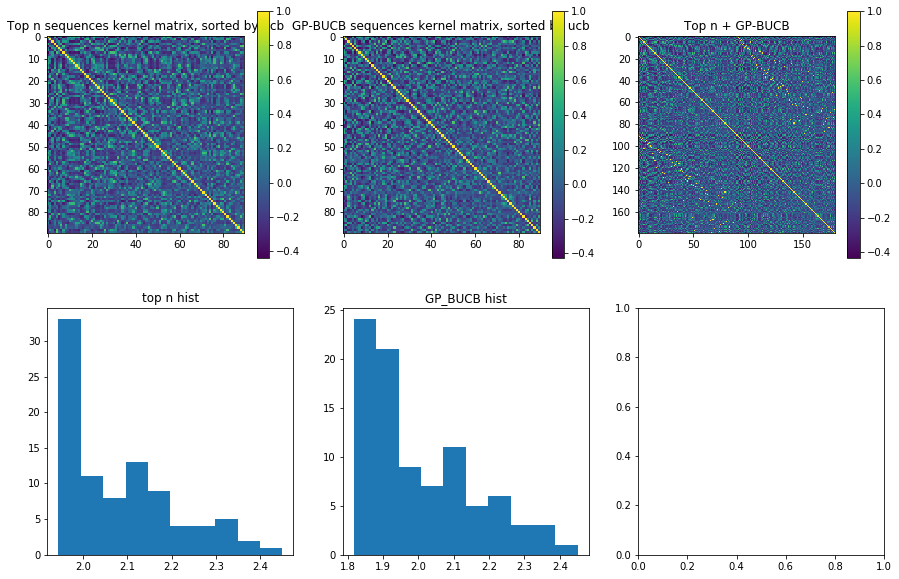

In [11]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(wd_kernel(l=6, features = np.asarray(top_n_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(wd_kernel(l=6, features = np.asarray(gpbucb_rec_df['RBS'])).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
fig.colorbar(im, ax =a[0][2])
a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [12]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  80


In [14]:
para_name = '_alpha' + str(alpha) + '_beta' + str(beta)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='r') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb' + para_name)